In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
from flask import jsonify

sys_config=json.load(open("config.json", 'r'))

# Root directory of the project
ROOT_DIR = os.path.abspath("/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import tst_cups as cup

%matplotlib inline 

Using TensorFlow backend.


In [2]:
config = cup.CupConfig()

class InferenceConfig(config.__class__):
    # Make sure we only run detection 1 at a time
    # This value may be increased when moved to cloud
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE=0.96

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.96
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [3]:
def get_ax(rows=1, cols=1, size=16):
    #This fn essentially allows a base size for graphs below
    #Common thing i've seen in notebooks with matplotlib
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
# Load validation dataset
dataset = cup.CupDataset()
dataset.load_cup(sys_config["cup directory"], "val")

# Must call before using the dataset as per mrcnn
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 3
Classes: ['BG', 'cup']


In [5]:
# Create model in inference mode
with tf.device(sys_config["device"]):
    model = modellib.MaskRCNN(mode=sys_config["mode"], model_dir=sys_config["model directory"],
                              config=config)
    
try:
    print("Loading weights ", sys_config["weights path"])
    model.load_weights(sys_config["weights path"], by_name=True)
except:
    print("Weights file unable to be loaded".format(error))

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights  C:\Users\AdamG\OneDrive\Documents\Projects\Uni\FYP\API\logs\initial_cups\mask_rcnn_cup_0017.h5


In [6]:
print(dataset.image_ids)

[0 1 2]


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  137.20000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  225.00000  max:  978.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


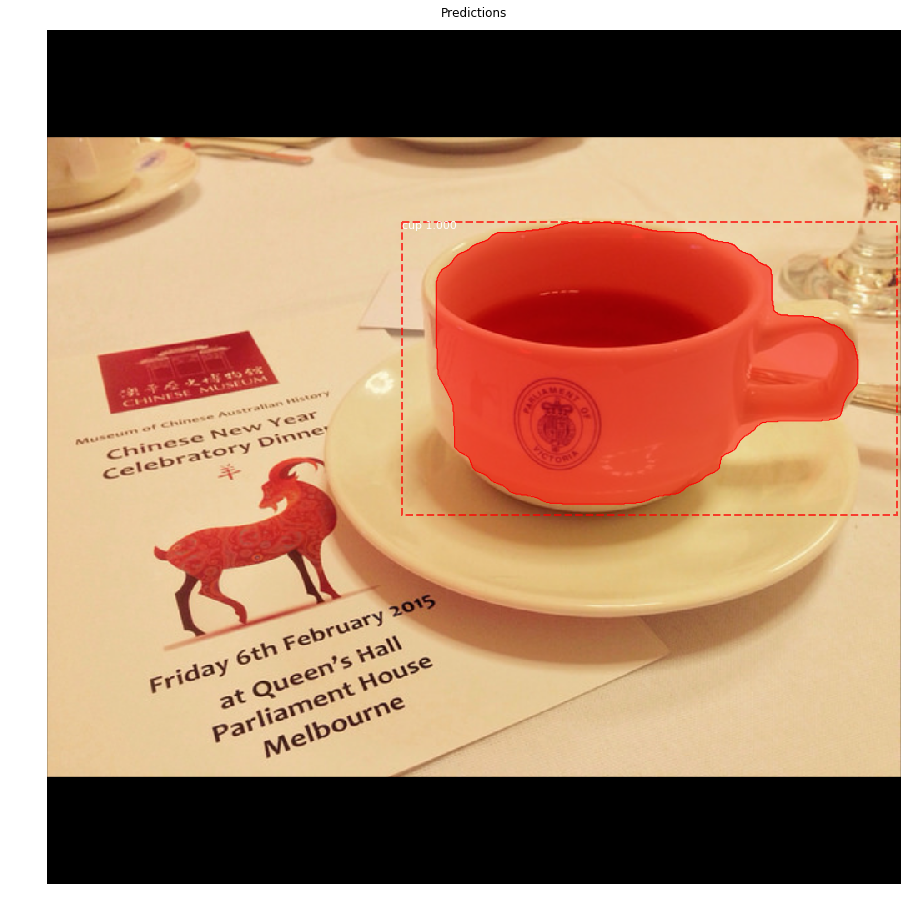

In [7]:

image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, random.choice(dataset.image_ids), use_mini_mask=False)

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax()
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [8]:
print (r['rois'])
print ("-------------------")
print (r['rois'][0])

[[ 229  425  581 1019]]
-------------------
[ 229  425  581 1019]


In [57]:
#rois: [N, (y1, x1, y2, x2)] detection bounding boxes
#Will return x, y, relative x, relative y, and cropped image
def final_ret(image, roi):
    img=image[roi[0]:roi[2], roi[1]:roi[3]]
    centre = find_box_center(roi, image)
    plt.imshow(img)
    return json.dumps({"image":img.tolist(), "centre": centre})

In [58]:
def find_box_center(roi, image):
    true_y = (roi[0]+roi[2])/2
    true_x = (roi[1]+roi[3])/2
    rel_roi = []
    for i in roi:
        #The shape of the image is normalised to square so we don't need to
        #worry about different x and y shapes
        rel_roi.append((i/image.shape[0])*100)
    rel_y = np.round((rel_roi[0]+rel_roi[2])/2, 2)
    rel_x = np.round((rel_roi[1]+rel_roi[3])/2, 2)

    return ([true_y, true_x, rel_y, rel_x])

In [59]:
def detect_boxes_and_crop(image):
    imgs=[]
    for i in range(len(r['rois'])):
        plt.axis('off')
        box_ret = final_ret(image, r['rois'][i])
        filename=("detect_tst_{}.png".format(i))
        imgs.append(box_ret)
    return imgs

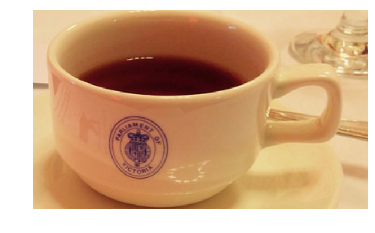

In [60]:
image_list=detect_boxes_and_crop(image)
with open('test_data.json', 'w') as outfile:
    json.dump(image_list, outfile)